In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# define transform function to constrain parameter values
@jit
def transform(param):
    
    # make sure param is positive
    param_pos = jnp.log10(1. + 10 ** param)
    
    return param_pos

# ode 
@jit
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma, lmbda = params
    
    # make sure parameters are non-negative
    mu_max = transform(mu_max)
    pref = transform(pref)
    Sigma_inv = transform(Sigma_inv)
    K_inv = transform(K_inv)
    delta = transform(delta)
    
    # unpack variables
    od, pH = x 
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp2(-Sigma_inv * (pH - pref)**2.) - delta) 
    dpH = (gamma * od + lmbda * dod) * (pH * (1. - pH / 14.))
    
    return jnp.array([dod, dpH])  

# define prior mean of untransformed variables 
prior_mean = np.array([1., 7., 1., 1., 1., 0., 0.])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [4]:
all_species = df.columns.values[3:]
all_species

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD'],
      dtype=object)

In [5]:
sp = all_species[9][:-3]
sp

'delarc'

In [6]:
df_species = pd.concat([df_exp[['Treatments', 'Time', 'pH', sp+'_OD']] 
                   for exp_name, df_exp in df.groupby("Treatments") if sp in exp_name])
df_species

,Treatments,Time,pH,delarc_OD
954,delarc_pH4_0,0,5.018455,0.010000
955,delarc_pH4_0,3,5.050176,0.010000
956,delarc_pH4_0,6,5.054316,0.010000
957,delarc_pH4_0,9,5.074718,0.010000
958,delarc_pH4_0,24,5.027032,0.010000
...,...,...,...,...
1039,delarc_pH9_2,0,8.132268,0.010000
1040,delarc_pH9_2,3,8.037141,0.189601
1041,delarc_pH9_2,6,7.416589,1.772155
1042,delarc_pH9_2,9,6.566121,3.735799


## Specify system state variables 

In [7]:
# names of species
species = [sp+'_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [8]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
                transform = transform,
                dataframe = df_species, 
                sys_vars = species, 
                prior_mean = prior_mean,
                alpha=1., nu2=.0001, sigma2=.001)

## Fit the parameter posterior

In [9]:
# fit to data 
t0 = time.time()
# ode_model.fit_posterior_EM(lr=1e-3, 
#                            tol=1e-3,
#                            n_sample_sgd = 5,
#                            n_sample_hypers= 100)
ode_model.fit_posterior(lr=1e-3, tol=1e-3, n_sample=10)

print("Elapsed time {:.2f}s".format(time.time()-t0))

Epoch 0, ELBO: -1348837.875, Slope: 1.000, Convergence: 0.00000
Epoch 10, ELBO: -1347768.750, Slope: 1.000, Convergence: 0.00040
Epoch 20, ELBO: -1342281.000, Slope: 0.002, Convergence: 0.00298
Epoch 30, ELBO: -2062380.125, Slope: -0.104, Convergence: -0.35210
Epoch 40, ELBO: -3656670.500, Slope: -0.146, Convergence: -0.87369
Epoch 50, ELBO: -3325453.750, Slope: -0.137, Convergence: -0.52504
Epoch 60, ELBO: -3281481.250, Slope: -0.118, Convergence: -0.40364
Epoch 70, ELBO: -3310113.500, Slope: -0.101, Convergence: -0.34592
Epoch 80, ELBO: -3272998.500, Slope: -0.085, Convergence: -0.28364
Epoch 90, ELBO: -3269028.750, Slope: -0.073, Convergence: -0.24691
Epoch 100, ELBO: -3268614.500, Slope: -0.059, Convergence: -0.16169
Epoch 110, ELBO: -3268183.000, Slope: -0.039, Convergence: -0.08732
Epoch 120, ELBO: -3267622.500, Slope: -0.013, Convergence: -0.02169
Epoch 130, ELBO: -3267172.500, Slope: 0.007, Convergence: 0.01554
Epoch 140, ELBO: -3266076.750, Slope: 0.002, Convergence: 0.00415
p

Epoch 1210, ELBO: -1038062.562, Slope: -0.001, Convergence: 0.22698
Epoch 1220, ELBO: -632609.125, Slope: 0.021, Convergence: 0.50112
Epoch 1230, ELBO: -1092110.500, Slope: 0.019, Convergence: 0.11173
Epoch 1240, ELBO: -1309537.500, Slope: 0.011, Convergence: -0.06727
Epoch 1250, ELBO: -1553368.750, Slope: 0.015, Convergence: -0.20032
pass 1
Epoch 1260, ELBO: -1437086.750, Slope: 0.000, Convergence: -0.11771
fail 1
Epoch 1270, ELBO: -1611503.000, Slope: -0.002, Convergence: -0.20382
Epoch 1280, ELBO: -1491409.625, Slope: -0.018, Convergence: -0.12221
Epoch 1290, ELBO: -1274903.750, Slope: -0.025, Convergence: 0.02113
Epoch 1300, ELBO: -1167027.750, Slope: -0.032, Convergence: 0.07435
Epoch 1310, ELBO: -1030769.188, Slope: -0.015, Convergence: 0.18195
Epoch 1320, ELBO: -1270176.625, Slope: 0.011, Convergence: 0.04050
Epoch 1330, ELBO: -833735.125, Slope: 0.037, Convergence: 0.35765
Epoch 1340, ELBO: -1093356.000, Slope: 0.043, Convergence: 0.14336
Epoch 1350, ELBO: -1307194.500, Slope: 

Epoch 2390, ELBO: -1398379.000, Slope: -0.021, Convergence: -0.05662
Epoch 2400, ELBO: -1187793.625, Slope: -0.017, Convergence: 0.09303
Epoch 2410, ELBO: -1157269.625, Slope: -0.016, Convergence: 0.09963
fail 1
Epoch 2420, ELBO: -1643425.375, Slope: -0.028, Convergence: -0.25079
Epoch 2430, ELBO: -930271.938, Slope: -0.006, Convergence: 0.29204
Epoch 2440, ELBO: -1013169.000, Slope: 0.019, Convergence: 0.24477
Epoch 2450, ELBO: -923029.625, Slope: 0.042, Convergence: 0.31022
Epoch 2460, ELBO: -1059295.000, Slope: 0.046, Convergence: 0.18703
Epoch 2470, ELBO: -854921.938, Slope: 0.041, Convergence: 0.27058
Epoch 2480, ELBO: -1731371.125, Slope: 0.007, Convergence: -0.45507
Epoch 2490, ELBO: -1356492.625, Slope: -0.007, Convergence: -0.14404
Epoch 2500, ELBO: -841413.688, Slope: 0.004, Convergence: 0.26901
Epoch 2510, ELBO: -1224706.500, Slope: 0.002, Convergence: -0.05778
fail 1
Epoch 2520, ELBO: -1363599.125, Slope: -0.024, Convergence: -0.20691
Epoch 2530, ELBO: -1094989.625, Slope: 

Epoch 3560, ELBO: -470795.500, Slope: 0.097, Convergence: 0.67156
Epoch 3570, ELBO: -939662.062, Slope: 0.089, Convergence: 0.28451
Epoch 3580, ELBO: -826227.438, Slope: 0.081, Convergence: 0.31025
Epoch 3590, ELBO: -1977624.875, Slope: 0.035, Convergence: -0.65635
Epoch 3600, ELBO: -1675915.125, Slope: -0.007, Convergence: -0.45579
Epoch 3610, ELBO: -1443816.375, Slope: -0.025, Convergence: -0.25380
fail 1
Epoch 3620, ELBO: -1741851.625, Slope: -0.053, Convergence: -0.48043
Epoch 3630, ELBO: -1597145.500, Slope: -0.075, Convergence: -0.34576
Epoch 3640, ELBO: -1376505.500, Slope: -0.073, Convergence: -0.12074
Epoch 3650, ELBO: -1021494.125, Slope: -0.033, Convergence: 0.21851
pass 1
Epoch 3660, ELBO: -1083129.250, Slope: 0.001, Convergence: 0.20843
Epoch 3670, ELBO: -459984.438, Slope: 0.040, Convergence: 0.65162
Epoch 3680, ELBO: -1148931.250, Slope: 0.062, Convergence: 0.15060
Epoch 3690, ELBO: -1121048.125, Slope: 0.053, Convergence: 0.11518
Epoch 3700, ELBO: -1387651.750, Slope: 0

Epoch 4740, ELBO: -1553634.125, Slope: -0.024, Convergence: -0.09121
Epoch 4750, ELBO: -1161744.250, Slope: -0.018, Convergence: 0.16588
Epoch 4760, ELBO: -517787.500, Slope: 0.012, Convergence: 0.60642
Epoch 4770, ELBO: -906695.125, Slope: 0.033, Convergence: 0.30297
Epoch 4780, ELBO: -1240632.875, Slope: 0.043, Convergence: 0.05802
Epoch 4790, ELBO: -1577258.875, Slope: 0.021, Convergence: -0.20956
Epoch 4800, ELBO: -1131790.875, Slope: 0.019, Convergence: 0.10580
Epoch 4810, ELBO: -1632969.875, Slope: 0.013, Convergence: -0.24084
Epoch 4820, ELBO: -1271884.750, Slope: 0.004, Convergence: 0.00865
fail 1
Epoch 4830, ELBO: -1884440.375, Slope: -0.033, Convergence: -0.46321
Epoch 4840, ELBO: -1355706.625, Slope: -0.045, Convergence: -0.06909
Epoch 4850, ELBO: -1028946.000, Slope: -0.034, Convergence: 0.18000
Epoch 4860, ELBO: -600314.188, Slope: 0.011, Convergence: 0.52472
Epoch 4870, ELBO: -1120733.000, Slope: 0.028, Convergence: 0.12747
Epoch 4880, ELBO: -795461.125, Slope: 0.044, Con

Epoch 5930, ELBO: -1264660.250, Slope: -0.046, Convergence: -0.10871
Epoch 5940, ELBO: -964219.312, Slope: -0.037, Convergence: 0.14561
fail 1
Epoch 5950, ELBO: -977487.312, Slope: -0.020, Convergence: 0.14427
Epoch 5960, ELBO: -1050427.250, Slope: 0.006, Convergence: 0.11503
Epoch 5970, ELBO: -959825.875, Slope: 0.031, Convergence: 0.20426
Epoch 5980, ELBO: -1316008.125, Slope: 0.030, Convergence: -0.07578
Epoch 5990, ELBO: -758964.500, Slope: 0.039, Convergence: 0.34620
Epoch 6000, ELBO: -1108243.125, Slope: 0.024, Convergence: 0.00385
Epoch 6010, ELBO: -964758.750, Slope: 0.024, Convergence: 0.11060
pass 1
fail 1
Epoch 6020, ELBO: -1272375.875, Slope: -0.001, Convergence: -0.19618
fail 2
Epoch 6030, ELBO: -1758415.000, Slope: -0.030, Convergence: -0.57978
Epoch 6040, ELBO: -1503645.750, Slope: -0.036, Convergence: -0.28845
fail 1
Epoch 6050, ELBO: -1755597.375, Slope: -0.047, Convergence: -0.41032
Epoch 6060, ELBO: -1414473.000, Slope: -0.045, Convergence: -0.10400
Epoch 6070, ELBO:

Epoch 7110, ELBO: -1697980.250, Slope: -0.049, Convergence: -0.31496
Epoch 7120, ELBO: -1264029.875, Slope: -0.034, Convergence: 0.04756
fail 1
Epoch 7130, ELBO: -1326488.875, Slope: -0.016, Convergence: 0.03407
Epoch 7140, ELBO: -1130997.875, Slope: -0.016, Convergence: 0.14822
Epoch 7150, ELBO: -912665.562, Slope: 0.011, Convergence: 0.31064
Epoch 7160, ELBO: -1316273.625, Slope: 0.026, Convergence: 0.03349
Epoch 7170, ELBO: -1594682.000, Slope: 0.020, Convergence: -0.14791
fail 1
Epoch 7180, ELBO: -1777941.250, Slope: -0.001, Convergence: -0.26672
Epoch 7190, ELBO: -1479070.375, Slope: 0.001, Convergence: -0.03834
fail 1
Epoch 7200, ELBO: -1608028.625, Slope: -0.016, Convergence: -0.13979
Epoch 7210, ELBO: -927816.000, Slope: -0.012, Convergence: 0.30438
fail 1
Epoch 7220, ELBO: -1551966.750, Slope: -0.016, Convergence: -0.13898
Epoch 7230, ELBO: -1053396.250, Slope: -0.005, Convergence: 0.21111
Epoch 7240, ELBO: -831107.812, Slope: 0.018, Convergence: 0.36328
Epoch 7250, ELBO: -640

Epoch 8300, ELBO: -784095.438, Slope: 0.008, Convergence: 0.30879
fail 1
Epoch 8310, ELBO: -1181774.125, Slope: -0.017, Convergence: -0.09929
Epoch 8320, ELBO: -1150740.750, Slope: -0.027, Convergence: -0.08428
fail 1
Epoch 8330, ELBO: -1232597.000, Slope: -0.021, Convergence: -0.11178
Epoch 8340, ELBO: -990424.688, Slope: -0.005, Convergence: 0.12343
Epoch 8350, ELBO: -1014754.250, Slope: 0.024, Convergence: 0.14702
Epoch 8360, ELBO: -956254.688, Slope: 0.033, Convergence: 0.18283
Epoch 8370, ELBO: -1111520.000, Slope: 0.021, Convergence: 0.01367
fail 1
Epoch 8380, ELBO: -1212441.250, Slope: -0.010, Convergence: -0.13575
fail 2
Epoch 8390, ELBO: -1340819.375, Slope: -0.019, Convergence: -0.22166
Epoch 8400, ELBO: -618636.938, Slope: 0.016, Convergence: 0.42772
Epoch 8410, ELBO: -1036894.562, Slope: 0.013, Convergence: 0.02777
fail 1
Epoch 8420, ELBO: -2032640.750, Slope: -0.020, Convergence: -0.76032
Epoch 8430, ELBO: -1126630.250, Slope: -0.022, Convergence: 0.01527
Epoch 8440, ELBO:

fail 2
Epoch 9480, ELBO: -1754424.000, Slope: -0.044, Convergence: -0.34625
Epoch 9490, ELBO: -1323553.875, Slope: -0.030, Convergence: 0.01516
fail 1
Epoch 9500, ELBO: -1617410.625, Slope: -0.029, Convergence: -0.15832
Epoch 9510, ELBO: -1417792.875, Slope: -0.023, Convergence: -0.00187
Epoch 9520, ELBO: -1003947.812, Slope: -0.007, Convergence: 0.27377
Epoch 9530, ELBO: -894053.188, Slope: 0.025, Convergence: 0.35135
Epoch 9540, ELBO: -486705.531, Slope: 0.054, Convergence: 0.62367
Epoch 9550, ELBO: -1287980.625, Slope: 0.048, Convergence: -0.01038
Epoch 9560, ELBO: -1941082.500, Slope: 0.023, Convergence: -0.45148
Epoch 9570, ELBO: -1724131.375, Slope: 0.002, Convergence: -0.28178
Epoch 9580, ELBO: -1436524.125, Slope: -0.015, Convergence: -0.09381
fail 1
Epoch 9590, ELBO: -1971749.375, Slope: -0.033, Convergence: -0.43073
Epoch 9600, ELBO: -1324576.625, Slope: -0.040, Convergence: 0.01800
Epoch 9610, ELBO: -1255295.500, Slope: -0.040, Convergence: 0.05801
fail 1
Epoch 9620, ELBO: -

Epoch 10650, ELBO: -780360.125, Slope: 0.044, Convergence: 0.34437
Epoch 10660, ELBO: -1362735.250, Slope: 0.043, Convergence: -0.11603
Epoch 10670, ELBO: -1208043.500, Slope: 0.035, Convergence: -0.00673
Epoch 10680, ELBO: -1891643.000, Slope: 0.010, Convergence: -0.48988
Epoch 10690, ELBO: -1756487.000, Slope: -0.015, Convergence: -0.36394
Epoch 10700, ELBO: -1464330.000, Slope: -0.030, Convergence: -0.14562
Epoch 10710, ELBO: -1353362.250, Slope: -0.042, Convergence: -0.07697
fail 1
Epoch 10720, ELBO: -1464069.875, Slope: -0.055, Convergence: -0.16432
Epoch 10730, ELBO: -1438846.375, Slope: -0.045, Convergence: -0.09129
pass 1
Epoch 10740, ELBO: -787127.000, Slope: 0.000, Convergence: 0.41725
Epoch 10750, ELBO: -860216.188, Slope: 0.034, Convergence: 0.36688
Epoch 10760, ELBO: -1164627.625, Slope: 0.040, Convergence: 0.13014
Epoch 10770, ELBO: -1051984.000, Slope: 0.053, Convergence: 0.20501
Epoch 10780, ELBO: -1099864.625, Slope: 0.042, Convergence: 0.11593
Epoch 10790, ELBO: -1260

Epoch 11820, ELBO: -984632.000, Slope: -0.012, Convergence: 0.31803
Epoch 11830, ELBO: -892603.812, Slope: 0.022, Convergence: 0.38002
Epoch 11840, ELBO: -530099.062, Slope: 0.068, Convergence: 0.62310
Epoch 11850, ELBO: -1061795.250, Slope: 0.064, Convergence: 0.20396
Epoch 11860, ELBO: -1507048.500, Slope: 0.053, Convergence: -0.12951
Epoch 11870, ELBO: -1195639.500, Slope: 0.042, Convergence: 0.06441
Epoch 11880, ELBO: -1441387.375, Slope: 0.021, Convergence: -0.15566
pass 1
Epoch 11890, ELBO: -1190229.875, Slope: -0.000, Convergence: -0.01319
fail 1
Epoch 11900, ELBO: -1644635.375, Slope: -0.040, Convergence: -0.41592
Epoch 11910, ELBO: -1011683.062, Slope: -0.036, Convergence: 0.11719
fail 1
Epoch 11920, ELBO: -1212616.875, Slope: -0.031, Convergence: -0.03751
fail 2
Epoch 11930, ELBO: -1639097.875, Slope: -0.036, Convergence: -0.31821
Epoch 11940, ELBO: -1466227.875, Slope: -0.014, Convergence: -0.09663
fail 1
Epoch 11950, ELBO: -1538011.500, Slope: -0.010, Convergence: -0.11075


Epoch 12990, ELBO: -950634.125, Slope: -0.009, Convergence: 0.26464
Epoch 13000, ELBO: -696713.312, Slope: 0.029, Convergence: 0.45974
Epoch 13010, ELBO: -596011.250, Slope: 0.049, Convergence: 0.51080
Epoch 13020, ELBO: -733463.438, Slope: 0.062, Convergence: 0.37088
Epoch 13030, ELBO: -1768199.625, Slope: 0.042, Convergence: -0.44887
pass 1
fail 1
Epoch 13040, ELBO: -1911559.625, Slope: -0.000, Convergence: -0.55499
Epoch 13050, ELBO: -1910799.250, Slope: -0.032, Convergence: -0.51477
Epoch 13060, ELBO: -1469289.750, Slope: -0.049, Convergence: -0.17350
Epoch 13070, ELBO: -1363515.000, Slope: -0.042, Convergence: -0.05632
Epoch 13080, ELBO: -623862.750, Slope: -0.031, Convergence: 0.48115
Epoch 13090, ELBO: -334578.062, Slope: 0.003, Convergence: 0.70672
Epoch 13100, ELBO: -1295135.625, Slope: 0.014, Convergence: -0.07870
Epoch 13110, ELBO: -1037326.750, Slope: 0.039, Convergence: 0.16665
Epoch 13120, ELBO: -1431241.375, Slope: 0.052, Convergence: -0.08877
Epoch 13130, ELBO: -1651652

fail 2
Epoch 14160, ELBO: -1485659.250, Slope: -0.002, Convergence: -0.08862
Epoch 14170, ELBO: -1051744.625, Slope: 0.017, Convergence: 0.23135
Epoch 14180, ELBO: -1700228.625, Slope: 0.015, Convergence: -0.19552
Epoch 14190, ELBO: -1259535.500, Slope: 0.017, Convergence: 0.10011
Epoch 14200, ELBO: -1089876.250, Slope: 0.005, Convergence: 0.16302
Epoch 14210, ELBO: -783709.500, Slope: 0.013, Convergence: 0.36187
Epoch 14220, ELBO: -423688.156, Slope: 0.034, Convergence: 0.62714
Epoch 14230, ELBO: -633624.938, Slope: 0.052, Convergence: 0.41861
Epoch 14240, ELBO: -1450894.500, Slope: 0.043, Convergence: -0.28040
Epoch 14250, ELBO: -1152590.750, Slope: 0.030, Convergence: -0.04481
Epoch 14260, ELBO: -1489605.250, Slope: 0.002, Convergence: -0.34983
Epoch 14270, ELBO: -1195809.000, Slope: 0.001, Convergence: -0.06964
Epoch 14280, ELBO: -767111.438, Slope: -0.012, Convergence: 0.25134
fail 1
Epoch 14290, ELBO: -1255632.500, Slope: -0.031, Convergence: -0.22590
fail 2
Epoch 14300, ELBO: -1

Epoch 15330, ELBO: -1373212.750, Slope: 0.021, Convergence: -0.10378
Epoch 15340, ELBO: -1003798.250, Slope: 0.039, Convergence: 0.19870
Epoch 15350, ELBO: -1040973.938, Slope: 0.028, Convergence: 0.11068
Epoch 15360, ELBO: -1260632.625, Slope: 0.008, Convergence: -0.10789
fail 1
Epoch 15370, ELBO: -1616688.125, Slope: -0.015, Convergence: -0.37919
fail 2
Epoch 15380, ELBO: -1845003.000, Slope: -0.041, Convergence: -0.51561
Epoch 15390, ELBO: -1758065.750, Slope: -0.056, Convergence: -0.38228
fail 1
Epoch 15400, ELBO: -2020257.125, Slope: -0.060, Convergence: -0.46235
Epoch 15410, ELBO: -1267849.375, Slope: -0.037, Convergence: 0.11406
Epoch 15420, ELBO: -1040495.938, Slope: -0.016, Convergence: 0.26865
Epoch 15430, ELBO: -995504.938, Slope: -0.003, Convergence: 0.28119
Epoch 15440, ELBO: -1160059.000, Slope: 0.015, Convergence: 0.17171
Epoch 15450, ELBO: -1300862.250, Slope: 0.030, Convergence: 0.08810
Epoch 15460, ELBO: -1959189.750, Slope: 0.021, Convergence: -0.30927
Epoch 15470, E

Epoch 16500, ELBO: -933754.938, Slope: 0.044, Convergence: 0.24851
Epoch 16510, ELBO: -980144.438, Slope: 0.058, Convergence: 0.20441
Epoch 16520, ELBO: -1012381.000, Slope: 0.051, Convergence: 0.13723
Epoch 16530, ELBO: -1290478.500, Slope: 0.039, Convergence: -0.10967
Epoch 16540, ELBO: -1623586.250, Slope: 0.001, Convergence: -0.42178
Epoch 16550, ELBO: -1591978.750, Slope: -0.037, Convergence: -0.40789
Epoch 16560, ELBO: -1003083.625, Slope: -0.046, Convergence: 0.07569
Epoch 16570, ELBO: -801656.312, Slope: -0.034, Convergence: 0.24581
Epoch 16580, ELBO: -680537.375, Slope: 0.004, Convergence: 0.37387
Epoch 16590, ELBO: -1063336.625, Slope: 0.011, Convergence: 0.03165
Epoch 16600, ELBO: -1161197.625, Slope: 0.015, Convergence: -0.03601
Epoch 16610, ELBO: -1308921.000, Slope: 0.015, Convergence: -0.13453
Epoch 16620, ELBO: -1310253.625, Slope: 0.015, Convergence: -0.10710
Epoch 16630, ELBO: -1254682.125, Slope: 0.009, Convergence: -0.06336
Epoch 16640, ELBO: -1153911.625, Slope: -0

Epoch 17670, ELBO: -872623.938, Slope: -0.043, Convergence: 0.24628
fail 1
Epoch 17680, ELBO: -1596915.875, Slope: -0.034, Convergence: -0.26524
Epoch 17690, ELBO: -1233132.000, Slope: -0.032, Convergence: 0.02304
fail 1
Epoch 17700, ELBO: -1434716.500, Slope: -0.019, Convergence: -0.07872
fail 2
Epoch 17710, ELBO: -1524249.250, Slope: -0.002, Convergence: -0.08045
Epoch 17720, ELBO: -1191144.125, Slope: 0.012, Convergence: 0.15631
Epoch 17730, ELBO: -1371786.000, Slope: 0.011, Convergence: 0.02056
Epoch 17740, ELBO: -1124997.000, Slope: 0.021, Convergence: 0.18380
fail 1
Epoch 17750, ELBO: -1717761.625, Slope: -0.006, Convergence: -0.25734
Epoch 17760, ELBO: -1673297.750, Slope: -0.025, Convergence: -0.21777
Epoch 17770, ELBO: -1521317.625, Slope: -0.010, Convergence: -0.05725
Epoch 17780, ELBO: -1004314.438, Slope: -0.002, Convergence: 0.27206
Epoch 17790, ELBO: -1133970.875, Slope: 0.011, Convergence: 0.17214
Epoch 17800, ELBO: -927296.562, Slope: 0.023, Convergence: 0.29698
Epoch 1

fail 1
Epoch 18830, ELBO: -1562149.625, Slope: -0.011, Convergence: -0.34524
Epoch 18840, ELBO: -1014091.500, Slope: -0.007, Convergence: 0.11407
fail 1
Epoch 18850, ELBO: -1120930.625, Slope: -0.009, Convergence: 0.01347
Epoch 18860, ELBO: -1083083.375, Slope: -0.002, Convergence: 0.05094
Epoch 18870, ELBO: -1039637.188, Slope: 0.010, Convergence: 0.09656
fail 1
Epoch 18880, ELBO: -1248888.625, Slope: -0.006, Convergence: -0.10283
Epoch 18890, ELBO: -1022281.875, Slope: 0.003, Convergence: 0.09776
Epoch 18900, ELBO: -1151756.250, Slope: 0.013, Convergence: 0.00763
fail 1
Epoch 18910, ELBO: -1507341.875, Slope: -0.011, Convergence: -0.29078
fail 2
Epoch 18920, ELBO: -1976820.125, Slope: -0.023, Convergence: -0.55325
Epoch 18930, ELBO: -1885413.125, Slope: -0.049, Convergence: -0.44473
Epoch 18940, ELBO: -1306834.750, Slope: -0.039, Convergence: 0.02058
fail 1
Epoch 18950, ELBO: -2069071.500, Slope: -0.050, Convergence: -0.44780
Epoch 18960, ELBO: -1193648.875, Slope: -0.033, Convergenc

Epoch 19990, ELBO: -1096413.125, Slope: 0.028, Convergence: 0.12878
Epoch 20000, ELBO: -735444.250, Slope: 0.046, Convergence: 0.39280
Epoch 20010, ELBO: -531892.562, Slope: 0.051, Convergence: 0.51712
Epoch 20020, ELBO: -944750.812, Slope: 0.043, Convergence: 0.07404
Epoch 20030, ELBO: -664025.438, Slope: 0.045, Convergence: 0.30891
Epoch 20040, ELBO: -1265426.250, Slope: 0.024, Convergence: -0.29698
Epoch 20050, ELBO: -1042738.875, Slope: 0.013, Convergence: -0.07927
fail 1
Epoch 20060, ELBO: -1682197.500, Slope: -0.016, Convergence: -0.63333
fail 2
Epoch 20070, ELBO: -1917046.125, Slope: -0.048, Convergence: -0.75293
Epoch 20080, ELBO: -1686580.750, Slope: -0.064, Convergence: -0.45816
fail 1
Epoch 20090, ELBO: -2168934.250, Slope: -0.080, Convergence: -0.71606
Epoch 20100, ELBO: -1468805.000, Slope: -0.069, Convergence: -0.09839
Epoch 20110, ELBO: -646302.562, Slope: -0.027, Convergence: 0.52079
pass 1
fail 1
Epoch 20120, ELBO: -776275.312, Slope: -0.000, Convergence: 0.41714
Epoch

fail 1
Epoch 21160, ELBO: -1429693.625, Slope: -0.032, Convergence: -0.26961
Epoch 21170, ELBO: -1168464.625, Slope: -0.030, Convergence: -0.02580
Epoch 21180, ELBO: -1071030.750, Slope: -0.026, Convergence: 0.05662
fail 1
Epoch 21190, ELBO: -1137154.375, Slope: -0.006, Convergence: 0.04127
fail 2
Epoch 21200, ELBO: -1390063.125, Slope: -0.011, Convergence: -0.14644
fail 3
Epoch 21210, ELBO: -1512744.625, Slope: -0.015, Convergence: -0.20481
Epoch 21220, ELBO: -1470030.375, Slope: -0.009, Convergence: -0.12168
Epoch 21230, ELBO: -1463264.875, Slope: -0.005, Convergence: -0.08646
Epoch 21240, ELBO: -1419024.000, Slope: -0.023, Convergence: -0.07367
fail 1
Epoch 21250, ELBO: -1426756.000, Slope: -0.019, Convergence: -0.05778
Epoch 21260, ELBO: -1320362.500, Slope: -0.022, Convergence: 0.01310
fail 1
Epoch 21270, ELBO: -1536364.000, Slope: -0.021, Convergence: -0.11762
Epoch 21280, ELBO: -1510649.250, Slope: -0.013, Convergence: -0.06486
Epoch 21290, ELBO: -509803.094, Slope: 0.032, Conve

Epoch 22320, ELBO: -1141801.250, Slope: -0.013, Convergence: 0.12570
Epoch 22330, ELBO: -1121078.875, Slope: -0.014, Convergence: 0.11587
fail 1
Epoch 22340, ELBO: -1647671.625, Slope: -0.018, Convergence: -0.24162
Epoch 22350, ELBO: -1380729.000, Slope: -0.014, Convergence: -0.02367
fail 1
Epoch 22360, ELBO: -1692984.375, Slope: -0.009, Convergence: -0.18925
Epoch 22370, ELBO: -1301321.750, Slope: -0.006, Convergence: 0.07750
Epoch 22380, ELBO: -1062398.500, Slope: 0.015, Convergence: 0.24308
Epoch 22390, ELBO: -697661.000, Slope: 0.035, Convergence: 0.47541
Epoch 22400, ELBO: -1293308.500, Slope: 0.019, Convergence: -0.01264
Epoch 22410, ELBO: -1093626.000, Slope: 0.019, Convergence: 0.12035
fail 1
Epoch 22420, ELBO: -2048097.500, Slope: -0.002, Convergence: -0.53543
Epoch 22430, ELBO: -1219302.500, Slope: 0.008, Convergence: 0.09259
fail 1
Epoch 22440, ELBO: -1538648.625, Slope: -0.007, Convergence: -0.15444
Epoch 22450, ELBO: -832042.625, Slope: 0.004, Convergence: 0.34892
fail 1
E

Epoch 23490, ELBO: -1006372.125, Slope: -0.064, Convergence: -0.05025
Epoch 23500, ELBO: -835678.875, Slope: -0.035, Convergence: 0.16411
fail 1
Epoch 23510, ELBO: -946591.625, Slope: -0.007, Convergence: 0.09837
Epoch 23520, ELBO: -740677.500, Slope: 0.034, Convergence: 0.31550
Epoch 23530, ELBO: -1399110.750, Slope: 0.016, Convergence: -0.27137
Epoch 23540, ELBO: -1305064.125, Slope: 0.014, Convergence: -0.15265
fail 1
Epoch 23550, ELBO: -1611278.625, Slope: -0.010, Convergence: -0.38244
fail 2
Epoch 23560, ELBO: -1994690.500, Slope: -0.040, Convergence: -0.63237
Epoch 23570, ELBO: -1345609.375, Slope: -0.043, Convergence: -0.09104
fail 1
Epoch 23580, ELBO: -1487864.500, Slope: -0.048, Convergence: -0.17405
Epoch 23590, ELBO: -833519.375, Slope: -0.027, Convergence: 0.33319
fail 1
Epoch 23600, ELBO: -1024495.438, Slope: -0.007, Convergence: 0.19261
Epoch 23610, ELBO: -1120483.875, Slope: 0.008, Convergence: 0.12890
Epoch 23620, ELBO: -1054496.625, Slope: 0.032, Convergence: 0.19972
E

pass 1
Epoch 24650, ELBO: -1054121.750, Slope: 0.001, Convergence: 0.05185
fail 1
Epoch 24660, ELBO: -1575428.750, Slope: -0.011, Convergence: -0.34944
Epoch 24670, ELBO: -1296558.375, Slope: -0.004, Convergence: -0.07386
Epoch 24680, ELBO: -1042291.312, Slope: -0.011, Convergence: 0.10334
fail 1
Epoch 24690, ELBO: -1059038.750, Slope: -0.014, Convergence: 0.06712
fail 2
Epoch 24700, ELBO: -1528319.250, Slope: -0.018, Convergence: -0.27738
fail 3
Epoch 24710, ELBO: -1536170.500, Slope: -0.028, Convergence: -0.24240
Epoch 24720, ELBO: -1533156.750, Slope: -0.020, Convergence: -0.17098
Epoch 24730, ELBO: -1370646.375, Slope: -0.024, Convergence: -0.04627
fail 1
Epoch 24740, ELBO: -1930072.250, Slope: -0.030, Convergence: -0.38597
Epoch 24750, ELBO: -853004.500, Slope: -0.003, Convergence: 0.37849
fail 1
Epoch 24760, ELBO: -1416239.875, Slope: -0.011, Convergence: -0.04400
Epoch 24770, ELBO: -1369017.000, Slope: -0.010, Convergence: -0.00383
pass 1
fail 1
Epoch 24780, ELBO: -1432945.750, 

Epoch 25810, ELBO: -1234631.000, Slope: -0.010, Convergence: 0.05641
fail 1
Epoch 25820, ELBO: -1372633.375, Slope: -0.002, Convergence: -0.02199
Epoch 25830, ELBO: -639049.750, Slope: 0.012, Convergence: 0.49193
fail 1
Epoch 25840, ELBO: -1935345.625, Slope: -0.014, Convergence: -0.48378
pass 1
Epoch 25850, ELBO: -1063459.375, Slope: 0.001, Convergence: 0.18434
Epoch 25860, ELBO: -1213206.375, Slope: 0.002, Convergence: 0.06054
Epoch 25870, ELBO: -1366448.750, Slope: 0.012, Convergence: -0.02394
Epoch 25880, ELBO: -1521200.250, Slope: 0.010, Convergence: -0.11625
Epoch 25890, ELBO: -805595.625, Slope: 0.007, Convergence: 0.35614
Epoch 25900, ELBO: -1197802.375, Slope: 0.005, Convergence: 0.03007
Epoch 25910, ELBO: -1194007.750, Slope: 0.006, Convergence: 0.02995
fail 1
Epoch 25920, ELBO: -1312958.500, Slope: -0.002, Convergence: -0.07188
Epoch 25930, ELBO: -1304207.250, Slope: 0.016, Convergence: -0.00990
fail 1
Epoch 25940, ELBO: -1417232.000, Slope: -0.012, Convergence: -0.14329
Epo

Epoch 26970, ELBO: -1686190.875, Slope: -0.031, Convergence: -0.16985
Epoch 26980, ELBO: -1254222.125, Slope: -0.016, Convergence: 0.13547
Epoch 26990, ELBO: -1240977.125, Slope: -0.017, Convergence: 0.11915
Epoch 27000, ELBO: -932880.438, Slope: -0.002, Convergence: 0.31646
Epoch 27010, ELBO: -1293548.000, Slope: 0.024, Convergence: 0.09003
Epoch 27020, ELBO: -966391.438, Slope: 0.040, Convergence: 0.30192
Epoch 27030, ELBO: -604013.250, Slope: 0.059, Convergence: 0.53376
Epoch 27040, ELBO: -1176554.000, Slope: 0.051, Convergence: 0.05880
Epoch 27050, ELBO: -1468085.125, Slope: 0.035, Convergence: -0.17738
Epoch 27060, ELBO: -1565338.750, Slope: 0.004, Convergence: -0.28431
Epoch 27070, ELBO: -1353748.875, Slope: -0.020, Convergence: -0.14185
fail 1
Epoch 27080, ELBO: -1386551.500, Slope: -0.030, Convergence: -0.15661
Epoch 27090, ELBO: -1026125.125, Slope: -0.026, Convergence: 0.12843
fail 1
Epoch 27100, ELBO: -1810840.125, Slope: -0.032, Convergence: -0.43136
Epoch 27110, ELBO: -131

In [10]:
# ode_model.estimate_evidence()

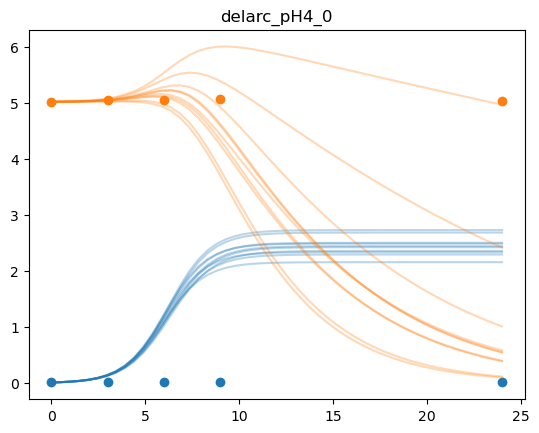

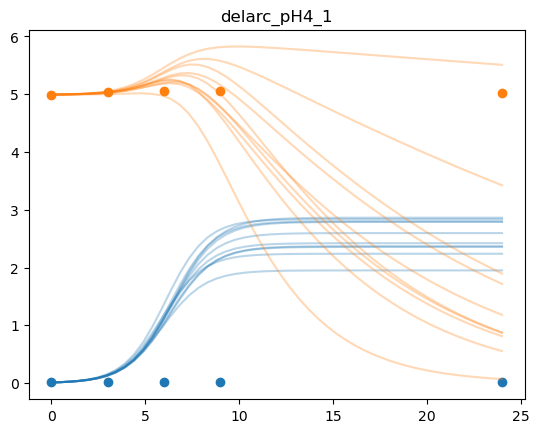

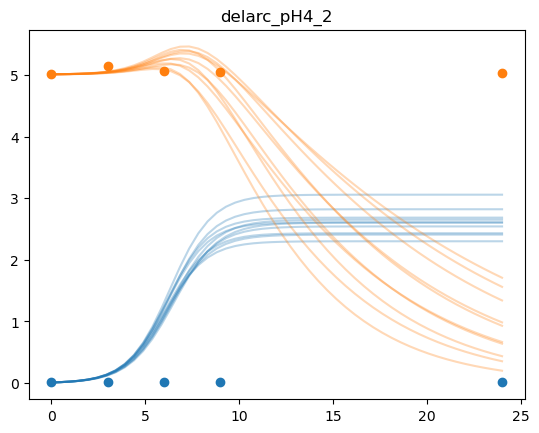

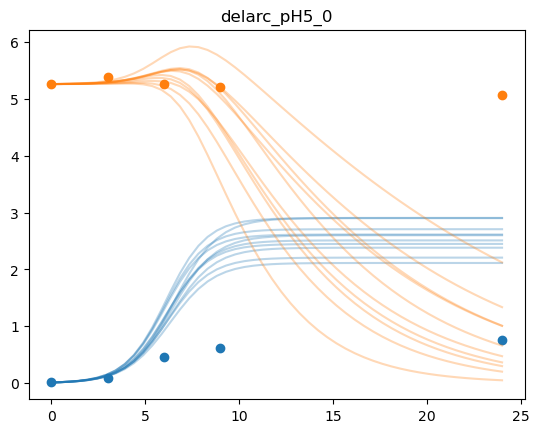

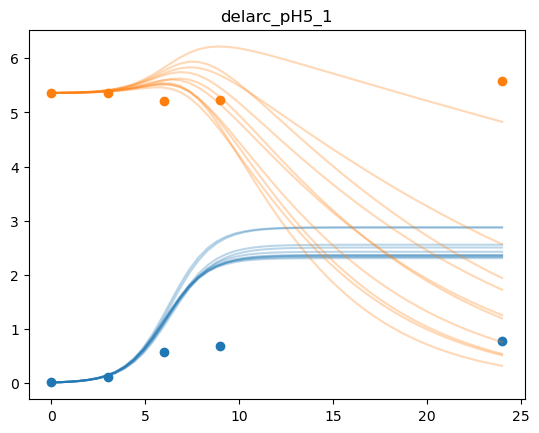

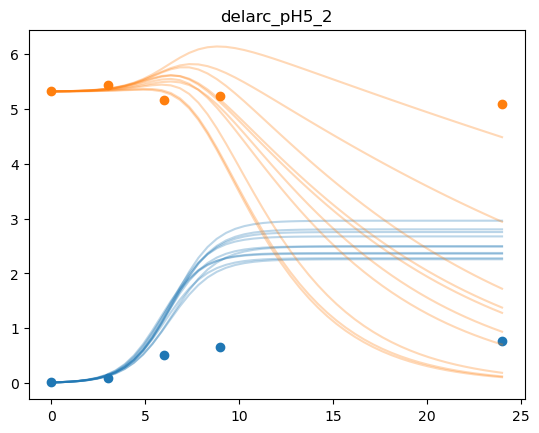

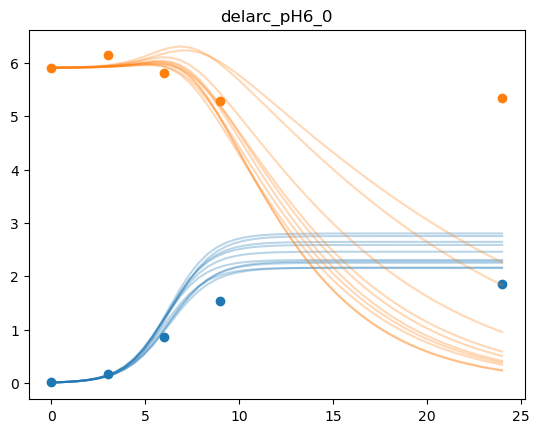

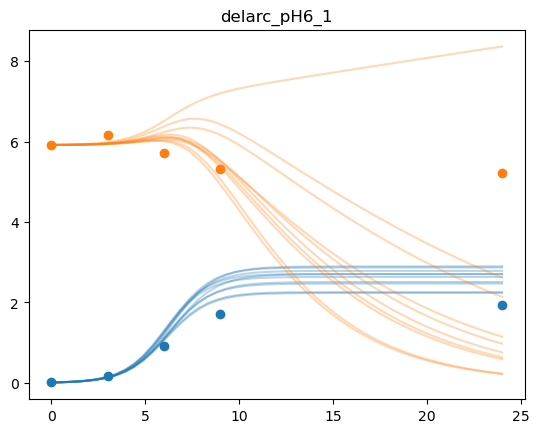

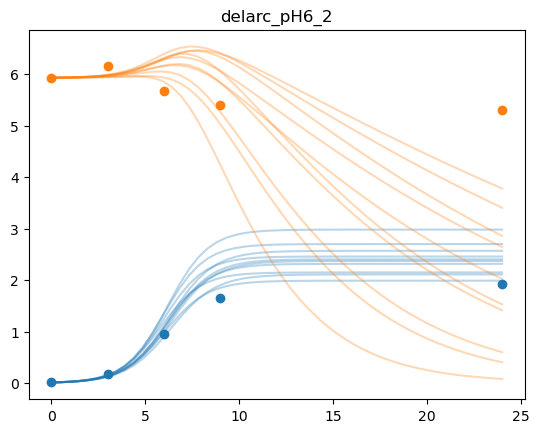

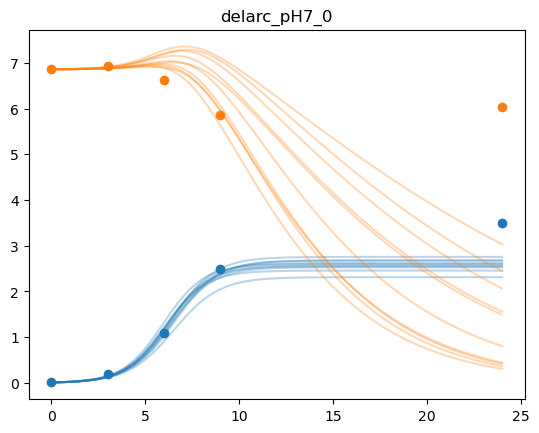

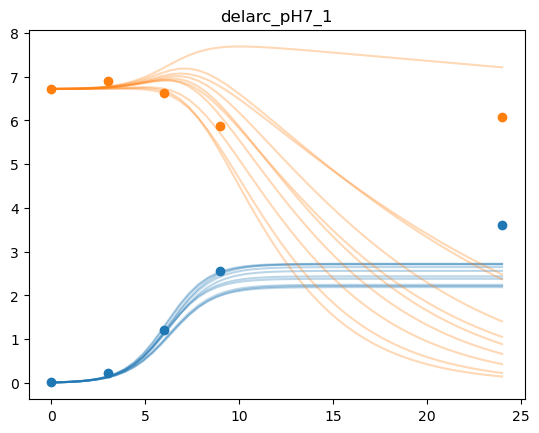

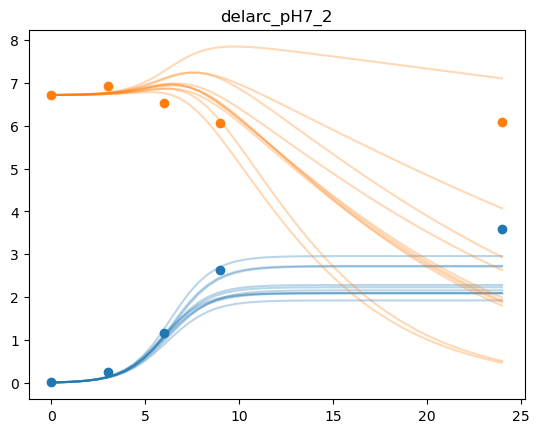

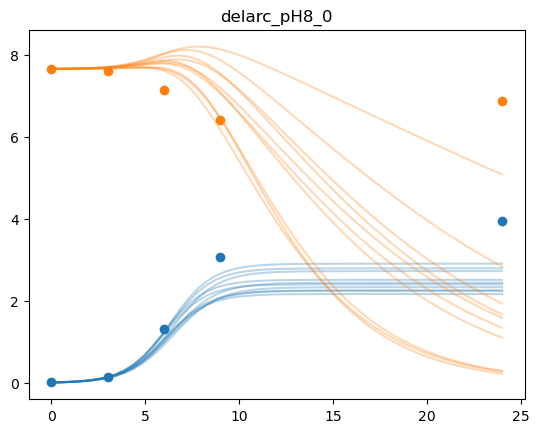

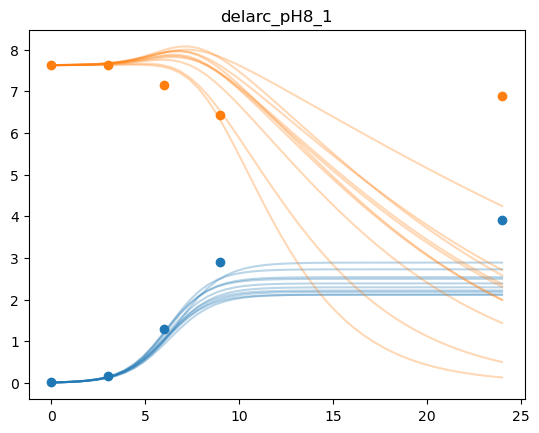

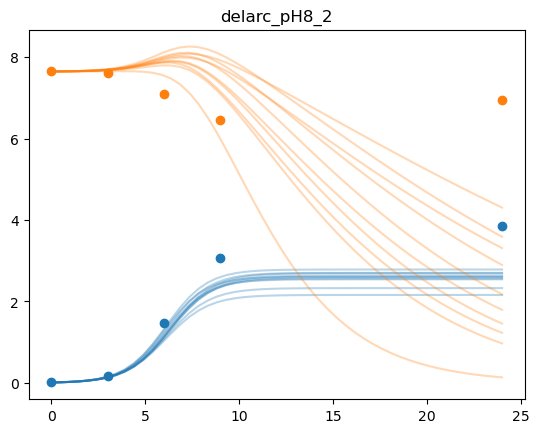

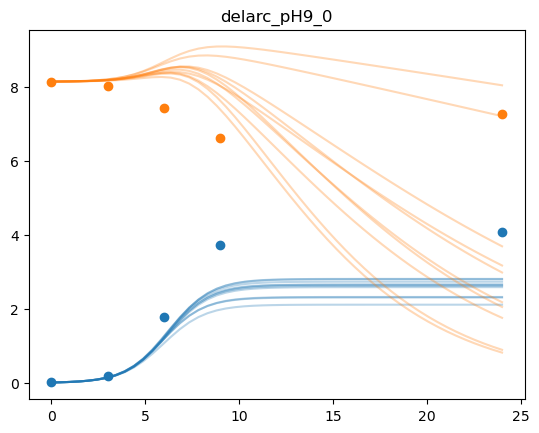

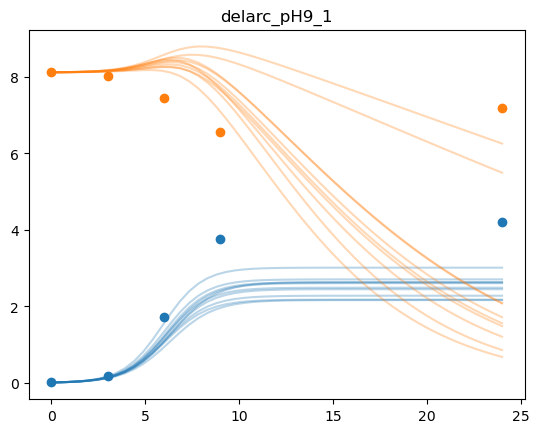

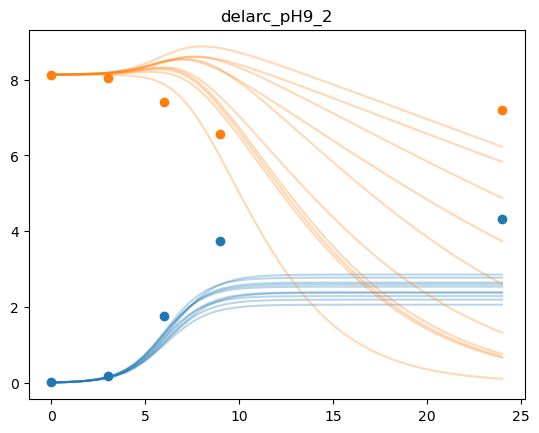

In [11]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_species.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    # y_preds = ode_model.predict_prior(x0, t_eval, n_sample=10)
    y_preds = ode_model.predict_sample(x0, t_eval, n_sample=10)
    
    # plot 
    for i, s in enumerate(species[:2]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

In [12]:
#ode_model.estimate_evidence(n_sample=1000, n_trials=3)

In [13]:
ode_model.param_df()

,mean,stdv
0,0.891424,0.021689
1,0.065601,1.306113
2,0.000009,0.000002
3,0.363284,0.037182
4,0.000439,0.000332
5,0.271740,0.011319
6,0.380339,0.003097


In [14]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params.to_csv('Fitting/'+sp+'_param.csv')